Notebook for exploring properties of network generation models

In [2]:
from scipy.stats.distributions import expon, binom, norm
import networkx as nx
import pandas as pd
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt
import torinanet as tn
from model import RandomGraphModel, PreferentialAttachmentModel, Distribution, SimulatedReactionGraph

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Compare network properties
Proof goodness of fit of pereferential attachement model by comparing it to known networks

In [38]:
# read data
import sys; sys.path.append("../data/literature/parsers")
real_rxngraph = tn.core.RxnGraph.from_file("../data/literature/ammonia.rxn")
real_G = real_rxngraph.to_networkx_graph(use_internal_id=True)

In [39]:
def generate_synthetic_graphs(nspeices, nreactions, ngraphs):
    model = PreferentialAttachmentModel(nspeices, nreactions, specie_energy_dist=expon(1))
    return [model.generate_graph() for _ in range(ngraphs)]

sreal_graphs = generate_synthetic_graphs(real_rxngraph.get_n_species(), real_rxngraph.get_n_reactions(), 10)

In [40]:

class DegreeTypes (Enum):
    IN = lambda g, s: len(list(g.predecessors(s)))
    OUT = lambda g, s: len(list(g.successors(s)))
    TOTAL = lambda g, s: len(list(g.successors(s))) + len(list(g.predecessors(s)))

def get_degrees_of_rxngraph(rxn_graph, G, degree_type: DegreeTypes):
    degrees = []
    for sp in rxn_graph.species:
        k = rxn_graph.specie_collection.get_key(sp)
        degrees.append(degree_type(G, k))
    return degrees

dtype = DegreeTypes.TOTAL
degrees = get_degrees_of_rxngraph(real_rxngraph, real_G, dtype)
sdegrees = []
for g in sreal_graphs:
    sdegrees += [dtype(g.g, s) for s in g.get_species()]

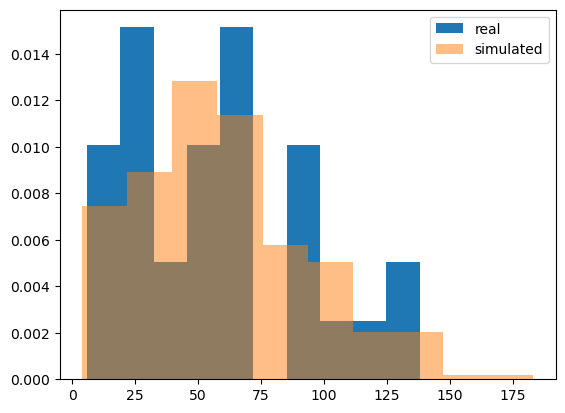

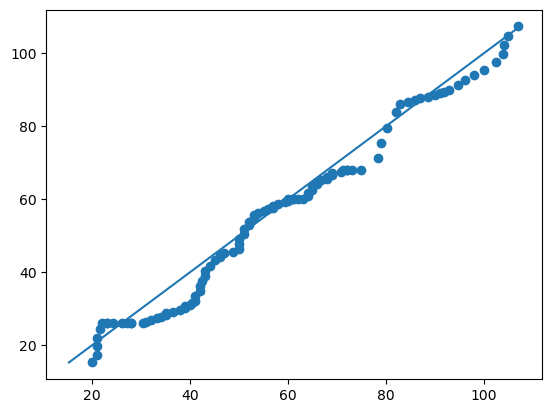

In [41]:
plt.hist(degrees, density=True, label="real")
plt.hist(sdegrees, density=True, alpha=0.5, label="simulated")
plt.legend()

quantiles = np.linspace(10, 90, 100)
true = np.percentile(degrees, quantiles)
pred = np.percentile(sdegrees, quantiles)
plt.figure()
plt.scatter(pred, true)
plt.plot(true, true)

# Reaction Energy Distribution

Enhance networks with their thermodynamic data. this contains the reaction energy based on atomization energy, enthalpy and gibbs free energy. first define a few helper functions

In [33]:
import sys; sys.path.append("../data/literature/parsers")
import torinanet as tn
from utils import NasaPolynomial
import json

def calculate_reaction_energy(rxn: tn.core.Reaction, specie_energy_func):
    """
    Add reaction energy based on atomization energy, species enthalpy and gibbs free energy. 
    """
    products_e = [specie_energy_func(s) for s in rxn.products]
    reactants_e = [specie_energy_func(s) for s in rxn.reactants]
    if None in products_e or None in reactants_e:
        return None
    return sum(products_e) - sum(reactants_e)

def _specie_enthalpy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature)

def _specie_entropy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.s(temperature)

def specie_entropy(temperature: float):
    return lambda sp: _specie_entropy(sp, temperature)

def specie_enthalpy(temperature: float):
    return lambda sp: _specie_enthalpy(sp, temperature)

def _specie_free_energy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature) - temperature * poly.s(temperature)

def specie_free_energy(temperature: float):
    return lambda sp: _specie_free_energy(sp, temperature)

def add_reaction_energies(rxn_graph: tn.core.RxnGraph, specie_energy_funcs: dict):
    """
    Add reaction energies to the reaction graph.
    """
    for rxn in rxn_graph.reactions:
        for name, func in specie_energy_funcs.items():
            e = calculate_reaction_energy(rxn, func)
            if e is not None:
                rxn.properties[name] = e
    return rxn_graph

def estimate_reaction_kinetics(rxn_graph: tn.core.RxnGraph, default_temperature: float=600):
    """
    Estimate reaction rate parameters
    """
    for rxn in rxn_graph.reactions:
        if not pd.isna(rxn.properties.get("rEa", pd.NA)) and \
            not pd.isna(rxn.properties.get("rA", pd.NA)) and \
            not pd.isna(rxn.properties.get("rbeta", pd.NA)):
            h = calculate_reaction_energy(rxn, specie_enthalpy(default_temperature))
            s = calculate_reaction_energy(rxn, specie_entropy(default_temperature))
            if h is None or s is None:
                continue
            rxn.properties["Ea"] = rxn.properties["rEa"] * 4.184 - h
            rxn.properties["A"] = rxn.properties["rA"] * np.exp(- s / 8.314)
            rxn.properties["beta"] = rxn.properties["rbeta"]
        if not pd.isna(rxn.properties.get("Ea", pd.NA)):
            # fix Ea to be in J/mol
            rxn.properties["Ea"] = rxn.properties["Ea"] * 4.184
    return rxn_graph

def rxn_properties_to_df(rxn_graph: tn.core.RxnGraph, properties: list):
    """
    Convert reaction properties to a pandas DataFrame.
    """
    data = []
    idx = []
    for rxn in rxn_graph.reactions:
        row = {prop: rxn.properties.get(prop, None) for prop in properties}
        idx.append(rxn_graph.reaction_collection.get_key(rxn))
        data.append(row)
    return pd.DataFrame(data, index=idx)

def graph_properties_df(g: tn.core.RxnGraph):
    funcs = {}
    for t in [300, 600, 900, 1200]:
        funcs[f"enthalpy_{t}"] = specie_enthalpy(t)
        funcs[f"free_energy_{t}"] = specie_free_energy(t)
    funcs["atomization_energy"] = lambda sp: sp.properties.get("atomization_energy", None)
    g = add_reaction_energies(g, funcs)
    g = estimate_reaction_kinetics(g)
    return rxn_properties_to_df(g, list(funcs.keys()) + ["Ea", "A", "beta", "rEa", "rA", "rbeta"])

check the temperature dependence of the thermo properties

In [37]:
base_path = "../data/literature/$.rxn"
graphs_paths = ["ammonia", "hydrogen", "methane"]
df = pd.DataFrame()
for path in graphs_paths:
    g = tn.core.RxnGraph.from_file(base_path.replace("$", path))
    ajr = graph_properties_df(g)
    ajr["graph"] = path
    ajr.index = [path + "." + x for x in ajr.index]
    df = pd.concat([df, ajr])
df

,enthalpy_300,free_energy_300,enthalpy_600,free_energy_600,enthalpy_900,free_energy_900,enthalpy_1200,free_energy_1200,atomization_energy,Ea,A,beta,rEa,rA,rbeta,graph
ammonia.N2O+OH->NH+NO2,270272.440524,264982.623767,269538.320151,259980.208609,268992.984593,255323.620537,268474.077372,250844.395078,NaN,-1.167487e+06,1.273147e+10,0.0,-2270.0,8.650000e+10,0.0,ammonia
ammonia.N2O->N2+O,167596.976227,127776.791542,169623.219798,86944.592836,169817.740235,45517.874349,169279.643126,4153.761622,NaN,2.620021e+05,1.260000e+12,0.0,NaN,NaN,NaN,ammonia
ammonia.H+NO->N+OH,202758.453619,199285.656742,202537.981046,195856.218915,201769.526814,192662.825005,200806.655466,189773.845688,NaN,-8.474189e+05,7.335639e+12,0.0,0.0,2.800000e+13,0.0,ammonia
ammonia.N+NO2->NO+NO,-324329.908317,-332739.920514,-324975.514394,-341056.739077,-326609.221986,-348754.707886,-328333.316553,-355876.635813,NaN,0.000000e+00,1.000000e+12,0.0,NaN,NaN,NaN,ammonia
ammonia.NNH+NO->HNO+N2,-233676.382430,-226855.722925,-234347.106124,-219808.299408,-235084.104066,-212367.745370,-235413.658691,-204730.057438,NaN,0.000000e+00,5.000000e+13,0.0,NaN,NaN,NaN,ammonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
methane.CH3OH+H->CH2OH+H2,-31663.207605,-37707.710894,-28852.977128,-45026.943527,-28424.040007,-53278.871348,-29377.554552,-61450.223482,-0.454968,2.037608e+04,1.700000e+07,2.1,NaN,NaN,NaN,methane
methane.CH+CO->HCCO,-309412.633836,-269197.579185,-310378.263942,-228345.557988,-309509.183431,-187484.133958,-308230.616836,-146998.938275,NaN,0.000000e+00,5.000000e+13,0.0,NaN,NaN,NaN,methane
methane.C3H7->C2H4+CH3,98917.598604,61739.268561,99858.429925,23931.410243,98635.947767,-13829.808499,96722.599944,-51026.993551,NaN,-3.180243e+05,6.255575e-01,1.6,5700.0,2.550000e+06,1.6,methane
methane.CH2CO+H->C2H3+O,378599.968977,367110.639821,376223.206131,356570.823931,374399.652894,347153.660601,372998.772420,338296.690333,NaN,-1.574118e+06,5.836703e+11,0.0,0.0,3.000000e+13,0.0,methane


In [ ]:
for p in ["enthalpy", "free_energy", "atomization_energy"]:
    plt.figure()
    if p == "atomization_energy":
        plt.hist(df[p].dropna(), alpha=0.5)
        plt.xlabel(f"{p} (Ha)")
        plt.ylabel("Count")
        print(p, len(df[p].dropna()))
    else:
        for t in [300, 600, 900, 1200]:
            plt.hist(df[f"{p}_{t}"].dropna() / 1000, density=True, alpha=0.5, label=f"T={t}K")
            print(p, t, len(df[f"{p}_{t}"].dropna()))
        plt.legend()
        plt.xlabel(f"{p} (kJ/mol)")
        plt.ylabel("Density")
    plt.title(f"{p.title()}")

In [17]:
import sqlite3
from openbabel import openbabel as ob
import pandas as pd

connection = sqlite3.connect("../data/joined.db")

def get_energy(smiles):
    return connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()[0][0]

def get_atomization_energy(smiles: str, atom_energies: dict):
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    return ajr - get_energy(smiles)


atom_energies = {"H": get_energy("[H]"), "N": get_energy("[N]"), "O": get_energy("[O]"), "C": get_energy("[C]")}
# get_atomization_energy("N[N]", atom_energies)
smiles_strings = connection.execute("SELECT smiles FROM species WHERE successful=1").fetchall()
atomization_energies = [get_atomization_energy(smiles[0], atom_energies) for smiles in smiles_strings]
atomization_energies_df = pd.DataFrame({"smiles": [s[0] for s in smiles_strings], "energy": atomization_energies})

connection.close()

KeyboardInterrupt: 

(array([0.02634045, 0.14675394, 0.38005508, 2.00187427, 2.4082698 ,
        2.85229454, 2.63028217, 1.25305288, 0.80150229, 0.25964159]),
 array([-0.15439082, -0.07602133,  0.00234817,  0.08071766,  0.15908716,
         0.23745665,  0.31582614,  0.39419564,  0.47256513,  0.55093463,
         0.62930412]),
 <BarContainer object of 10 artists>)

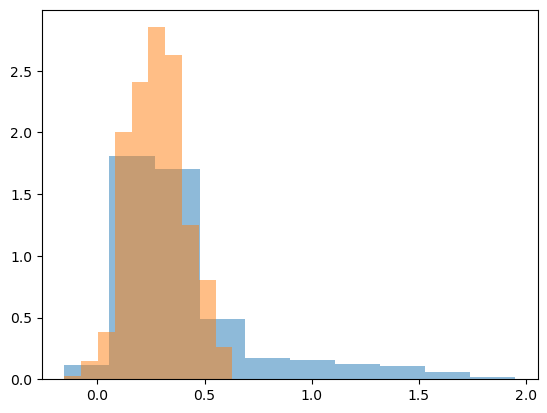

In [8]:
plt.hist(atomization_energies, density=True, alpha=0.5)
plt.hist(atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"], density=True, alpha=0.5)

In [9]:
print(atomization_energies_df["energy"].mean())
print(atomization_energies_df["energy"].std())

0.4076437635274041
0.33297794558844485


0.15104211483582117 0.11131442163222974


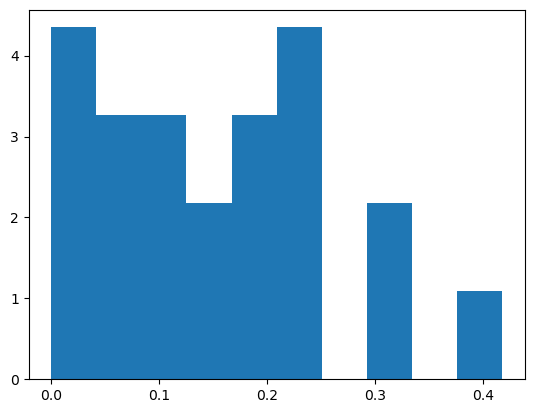

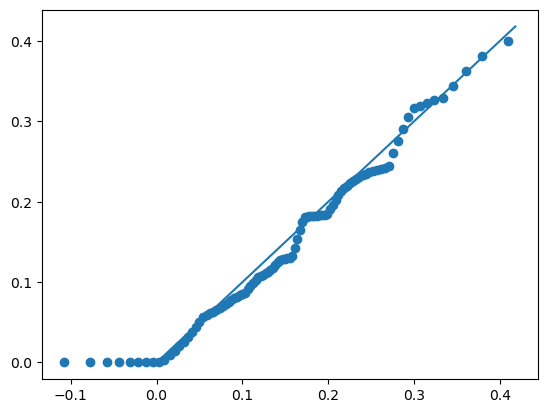

In [10]:
from scipy.stats import norm
energies = []
for s in real_rxngraph.species:
    if s.identifier in atomization_energies_df['smiles'].tolist():
        energies.append(atomization_energies_df[atomization_energies_df["smiles"] == s.identifier]["energy"].values[0])
senergies = []
for g in sreal_graphs:
    senergies += [g.nodes[s]["energy"] for s in g if "s" in s and not s == "s0"]

plt.hist(energies, density=True)
# plt.hist(senergies, density=True, alpha=0.5)

quantiles = np.linspace(0, 100, 100)
true = np.percentile(energies, quantiles)
# m = atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"].mean()
# s = atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"].std()
m = np.mean(energies)
s = np.std(energies)
print(m, s)
pred = [norm(m, s).isf(1 - x / 100) for x in quantiles]
plt.figure()
plt.scatter(pred, true)
plt.plot(true, true)

# Kinetic scaling relations
now we try to check out the scaling relations between reaction energy and max reaction rate

N REACTIONS 174
      T           a          b    error_mean  error_std       1/T
0   400 -117.365808  11.835013  3.348535e-15  26.891819  0.002500
1   600  -75.757246  18.047842  7.881307e-15  17.571730  0.001667
2   800  -54.892517  21.164945 -2.858505e-16  12.974584  0.001250
3  1000  -42.337721  23.041565  5.471996e-15  10.262026  0.001000
4  1200  -33.943977  24.296868  8.820531e-15   8.490137  0.000833
     property         slope      intecept        r2
0           a -5.004202e+04  7.701469e+00  0.999998
1           b -7.475153e+03  3.051622e+01  0.999997
2  error_mean -1.478921e-12  7.191739e-15  0.072079
3   error_std  1.105686e+04 -7.943808e-01  0.999938


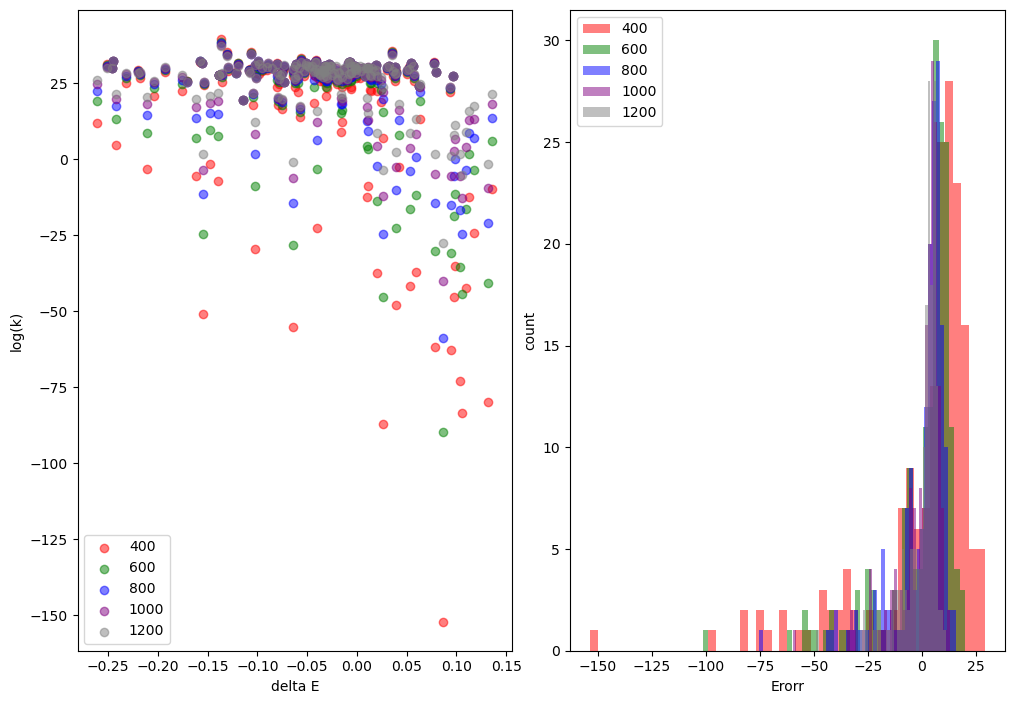

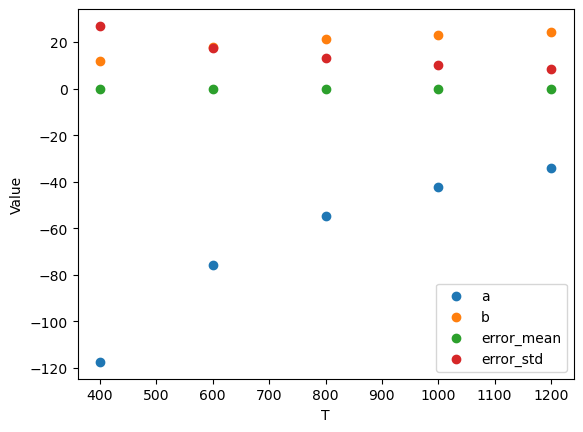

In [50]:
from scipy import stats
df = pd.read_csv("../data/konnov_scaling_data.csv", index_col=1)
print("N REACTIONS", len(df))
df = df.drop(columns=["Unnamed: 0"])

# add log k column
R = 8.314 # j / K mol
kb = 1.38e-23 # J / K
h = 6.626e-34 # J s
ha_to_J = 4.360e-18 # J / Ha
cal_to_J = 4.184 # J / cal

def calculate_rate_constants(df, T):
    ajr = df.copy()
    ajr["logk_arrhenius"] = np.log(ajr["A"]) + ajr["beta"] * np.log(T) - cal_to_J * ajr["Ea"] / (R * T)
    ajr["logk_eyring"] = np.log(kb / h) + np.log(T) - ha_to_J * ajr["deltaE"] / (kb * T)
    return ajr        

def summary_fit(df):
    data = []
    for col in df.columns:
        if col not in ["T", "1/T"]:
            a,b = np.polyfit(ajr["1/T"], ajr[col], deg=1)
            r2 = stats.pearsonr(ajr["1/T"], ajr[col]).statistic ** 2
            data.append([col, a, b, r2])
    return pd.DataFrame(data, columns=["property", "slope", "intecept", "r2"])

ajr = []
fig, axs = plt.subplots(ncols=2, figsize=(10, 7))
plt.tight_layout()
for T, color in zip([400, 600, 800, 1000, 1200], ["r", "g", "b", "purple", "gray"]):
    df = calculate_rate_constants(df, T)
    axs[0].scatter(df["deltaE"], df["logk_arrhenius"], label=T, c=color, alpha=0.5)
    a, b = np.polyfit(df["deltaE"], df["logk_arrhenius"], deg=1)
    r = df["logk_arrhenius"] - (a * df["deltaE"] + b)
    axs[1].hist(r, label=T, color=color, alpha=0.5, bins=50)
    ajr.append([T, a, b, np.mean(r), np.std(r)])
axs[0].set_xlabel("delta E")
axs[0].set_ylabel("log(k)")
axs[0].legend()
axs[1].set_xlabel("Erorr")
axs[1].set_ylabel("count")
axs[1].legend()


ajr = pd.DataFrame(ajr, columns=["T", "a", "b", "error_mean", "error_std"])
ajr["1/T"] = 1 / ajr["T"]
print(ajr)
plt.figure()
for c in ajr.columns:
    if c in ["T", "1/T"]:
        continue
    plt.scatter(ajr["T"], ajr[c], label=c)
plt.xlabel("T")
plt.ylabel("Value")
plt.legend()
print(summary_fit(ajr))


# Energy threshold reducing effect
here we estimate the effecct of the simplest reaction energy threshold and of the shortest path specie reducer

In [2]:
from energy_reducer_effect import single_run, apply_energy_th
from model import KineticSolver
from scipy.stats.distributions import expon, binom, norm
import networkx as nx
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt
import torinanet as tn
from model import RandomGraphModel, PreferentialAttachmentModel, Distribution, SimulatedReactionGraph

In [ ]:
def solve_kinetics(g: SimulatedReactionGraph):
    solver = KineticSolver(g, "k")
    g.set_origin()
    iconcs = [1 if s in s == g.origin else 0 for s in g.get_species()]
    step = 1e-13
    solver.solve_kinetics(100 * step, step, iconcs)
    return solver

def generate_network(n_species, n_reactions, sp_energy_dist, temperature):
    model = PreferentialAttachmentModel(n_species=n_species, 
                                            n_reactions=n_reactions, 
                                            specie_energy_dist=sp_energy_dist)
    g = model.generate_graph()
    log_difference_distribution = norm(0, 1.105686e4 / temperature - 7.943808e-1) # from konnov data
    g.add_kinetic_data(temperature, log_difference_distribution)
    # solve kinetics of graph and add data to it
    solution = solve_kinetics(g)
    concs = solution.concentrations_df()
    rates = solution.get_rates()
    total_rates = rates.sum(axis=1)
    relative_rates = rates.apply(lambda x: x / total_rates, axis=0)
    for s in g.get_species():
        g.get_properties(s)["concentration"] = concs[s]
    for r in g.get_reactions():
        g.get_properties(r)["rate"] = rates[r]
        g.get_properties(r)["relative_rate"] = relative_rates[r]
    return g

def make_graphs(nspecies, nreactions, ngraphs, min_participation_rate, sp_energy_dist, temperature):
    graphs = []
    while len(graphs) < ngraphs:
        print(len(graphs))
        g = generate_network(nspecies, nreactions, sp_energy_dist, temperature)
        # analyze participation
        participation = None
        for r in g.get_reactions():
            rate = g.get_properties(r)["rate"]
            p = np.where(rate > 0, 1, 0)
            if participation is None:
                participation = p
            else:
                participation += p
        if np.mean(participation) / len(g.get_reactions()) < min_participation_rate:
            continue
        graphs.append(g)
    return graphs

def analyze_reduction_accuracy(graphs, energy_th, ax=None):
    reduced = [apply_energy_th(g.copy(), energy_th, 0) for g in graphs]
    ajr = []
    for r, g in zip(reduced, graphs):
        covered_flux = np.sum([g.get_properties(r)["relative_rate"] for r in r.get_reactions()], axis=0)
        ajr.append(covered_flux)
    m = np.mean(ajr, axis=0)
    s = np.std(ajr, axis=0)
    time_points = list(range(len(m)))
    if ax is None:
        ax = plt.gca()
    ax.plot(time_points, m, label="E < " + str(round(energy_th, 2)))
    return reduced
    # ax.fill_between(time_points, np.clip(m - s, 0, 1), np.clip(m + s, 0, 1), color=ax.lines[-1].get_color(), alpha=0.3)



In [132]:
graphs = make_graphs(30, 1000, 10, 0.9, norm(0.4, 0.3), temperature=700)

0
1
1
2
2
2
2
2
3
4
4
4
5
5
6
7
7
8
9
9


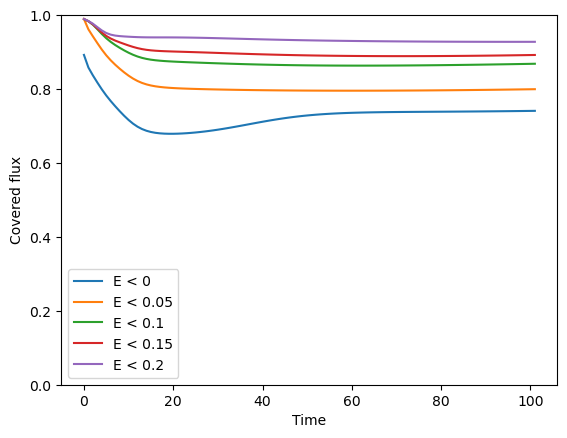

In [ ]:
for e in [0, 0.05, 0.1, 0.15, 0.2]:
    reduced = analyze_reduction_accuracy(graphs, e)
plt.xlabel("Time")
plt.ylabel("Covered flux")
plt.ylim(0, 1)
plt.legend()
# analyze size reduction 


In [ ]:
og, rg = run_reduction(30, 1000, norm(0.4, 0.3), energy_th=0.00, temperature=700)
rates = solve_kinetics(og)
total_rates = rates.sum(axis=1)
relative_rates = rates.apply(lambda x: x / total_rates, axis=0)

In [110]:
print(relative_rates.apply(lambda x: sum([r > 0 for r in x]), axis=1).mean(), relative_rates.apply(lambda x: sum([r > 0.001 for r in x]), axis=1).mean())

965.6274509803922 42.35294117647059


(0.0, 1.0)

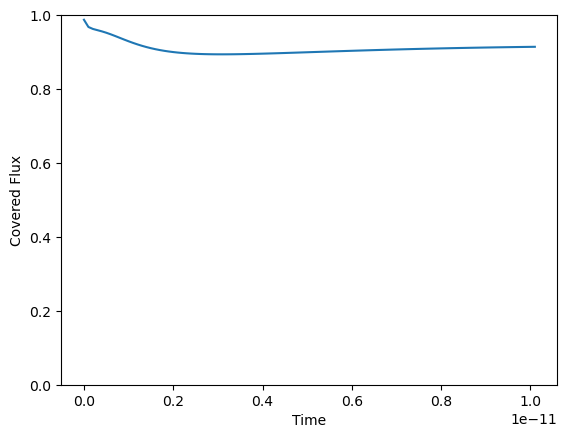

In [111]:
covered_flux = relative_rates[[rxn for rxn in rg.get_reactions()]].sum(axis=1)
plt.plot(covered_flux.index, covered_flux.values)
plt.xlabel("Time")
plt.ylabel("Covered Flux")
plt.ylim(0, 1)

In [ ]:
plt.hist([np.log(r) for r in rates.values() if not r == 0], label="original", alpha=0.7, density=True, bins=50)
reduced_rates = [np.log(rates[r]) for r in rg.get_reactions() if not rates[r] == 0]
plt.hist(reduced_rates, label="reduced", alpha=0.7, density=True, bins=50)
plt.legend()